In [41]:
from IPython import get_ipython
from IPython.display import display
from tensorflow.keras.datasets import boston_housing
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.metrics import RootMeanSquaredError
import numpy as np
from tensorflow import keras
from keras import models
from keras import layers


(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data() #載入數據集並分成訓練集和測試集(回歸問題)

# 新增區段

In [42]:
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

# 特徵名稱
feature_names = [
    "CRIM", "ZN", "INDUS", "CHAS", "NOX", "RM", "AGE", "DIS", "RAD", "TAX", "PTRATIO", "B", "LSTAT"
]

# 第一筆訓練資料
first_data = train_data[0]
first_target = train_targets[0]

explanations = [
    "每個城鎮的犯罪率",
    "住宅用地比例",
    "非零售商業用地比例",
    "查爾斯河虛擬變數",
    "氮氧化物濃度",
    "每戶平均房間數",
    "1940年之前建造的業主自用住宅比例",
    "到波士頓五個就業中心的加權距離",
    "高速公路可達性指數",
    "每$10,000美元的財產稅率",
    "每個城鎮的師生比例",
    "1000 * (Bk - 0.63)^2，其中Bk為該地區的黑人比例",
    "低社會經濟地位人口的百分比"
]


# 打印整齊的第一筆數據與解釋，確保冒號對齊
print(f"第一筆訓練資料：")
print("="*70)

for i, (name, value, explanation) in enumerate(zip(feature_names, first_data, explanations)):
    # 直接使用固定寬度對齊
    print(f"{name} - {explanation:} : {value}")

# 顯示房價中位數對應的資料
print("="*70)
print(f"MEDV (房價中位數): {first_target * 1000:,.2f} 美元")

第一筆訓練資料：
CRIM - 每個城鎮的犯罪率 : 1.23247
ZN - 住宅用地比例 : 0.0
INDUS - 非零售商業用地比例 : 8.14
CHAS - 查爾斯河虛擬變數 : 0.0
NOX - 氮氧化物濃度 : 0.538
RM - 每戶平均房間數 : 6.142
AGE - 1940年之前建造的業主自用住宅比例 : 91.7
DIS - 到波士頓五個就業中心的加權距離 : 3.9769
RAD - 高速公路可達性指數 : 4.0
TAX - 每$10,000美元的財產稅率 : 307.0
PTRATIO - 每個城鎮的師生比例 : 21.0
B - 1000 * (Bk - 0.63)^2，其中Bk為該地區的黑人比例 : 396.9
LSTAT - 低社會經濟地位人口的百分比 : 18.72
MEDV (房價中位數): 15,200.00 美元


In [43]:
test_data.shape #測試集有102筆數據，每筆有13個特徵

(102, 13)

In [44]:
train_targets #404個對應的房價

array([15.2, 42.3, 50. , 21.1, 17.7, 18.5, 11.3, 15.6, 15.6, 14.4, 12.1,
       17.9, 23.1, 19.9, 15.7,  8.8, 50. , 22.5, 24.1, 27.5, 10.9, 30.8,
       32.9, 24. , 18.5, 13.3, 22.9, 34.7, 16.6, 17.5, 22.3, 16.1, 14.9,
       23.1, 34.9, 25. , 13.9, 13.1, 20.4, 20. , 15.2, 24.7, 22.2, 16.7,
       12.7, 15.6, 18.4, 21. , 30.1, 15.1, 18.7,  9.6, 31.5, 24.8, 19.1,
       22. , 14.5, 11. , 32. , 29.4, 20.3, 24.4, 14.6, 19.5, 14.1, 14.3,
       15.6, 10.5,  6.3, 19.3, 19.3, 13.4, 36.4, 17.8, 13.5, 16.5,  8.3,
       14.3, 16. , 13.4, 28.6, 43.5, 20.2, 22. , 23. , 20.7, 12.5, 48.5,
       14.6, 13.4, 23.7, 50. , 21.7, 39.8, 38.7, 22.2, 34.9, 22.5, 31.1,
       28.7, 46. , 41.7, 21. , 26.6, 15. , 24.4, 13.3, 21.2, 11.7, 21.7,
       19.4, 50. , 22.8, 19.7, 24.7, 36.2, 14.2, 18.9, 18.3, 20.6, 24.6,
       18.2,  8.7, 44. , 10.4, 13.2, 21.2, 37. , 30.7, 22.9, 20. , 19.3,
       31.7, 32. , 23.1, 18.8, 10.9, 50. , 19.6,  5. , 14.4, 19.8, 13.8,
       19.6, 23.9, 24.5, 25. , 19.9, 17.2, 24.6, 13

In [45]:
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std
test_data -= mean
test_data /= std
#標準化數據，使其平均值為0，標準差為1，這樣可以讓梯度下降更有效率

###比較不同神經元數###

In [46]:
#原始model
def build_model_original():
    model = keras.Sequential([
        layers.Dense(64, activation="relu"),#64個神經元 activation使用relu
        layers.Dense(64, activation="relu"),
        layers.Dense(1)#最後一層只有1個神經元，因為是回歸問題，只需要輸出一個數值
    ])
    model.compile(optimizer="rmsprop", loss="mse", metrics=["mae", RootMeanSquaredError(), "mape"])
    return model
#原始model+多256神經元
def build_model_256():
    model = keras.Sequential([
        layers.Dense(256, activation="relu"),
        layers.Dense(256, activation="relu"),
        layers.Dense(1)
    ])
    model.compile(optimizer="rmsprop", loss="mse", metrics=["mae", RootMeanSquaredError(), "mape"])
    return model
#原始model+多1024神經元
def build_model_1024():
    model = keras.Sequential([
        layers.Dense(1024, activation="relu"),
        layers.Dense(1024, activation="relu"),
        layers.Dense(1)
    ])
    model.compile(optimizer="rmsprop", loss="mse", metrics=["mae", RootMeanSquaredError(), "mape"])
    return model
"""
#原始model+層數+改優化器
def build_model_adam():
    model = keras.Sequential([
        layers.Dense(64, activation="relu"),#64個神經元 activation使用relu
        layers.Dense(64, activation="relu"),
        layers.Dense(64, activation="relu"),
        layers.Dense(64, activation="relu"),
        layers.Dense(1)#最後一層只有1個神經元，因為是回歸問題，只需要輸出一個數值
    ])
    model.compile(optimizer="adam", loss="mse", metrics=["mae", RootMeanSquaredError(), "mape"])
    return model"""

'\n#原始model+層數+改優化器\ndef build_model_adam():\n    model = keras.Sequential([\n        layers.Dense(64, activation="relu"),#64個神經元 activation使用relu\n        layers.Dense(64, activation="relu"),\n        layers.Dense(64, activation="relu"),\n        layers.Dense(64, activation="relu"),\n        layers.Dense(1)#最後一層只有1個神經元，因為是回歸問題，只需要輸出一個數值\n    ])\n    model.compile(optimizer="adam", loss="mse", metrics=["mae", RootMeanSquaredError(), "mape"])\n    return model'

In [47]:
#原始神經元模型
model_original = build_model_original()
model_original.fit(train_data, train_targets,
                epochs=100, batch_size=16, verbose=0)
test_mse, test_mae, test_rmse, test_mape = model_original.evaluate(test_data, test_targets, verbose=0)#訓練模型用測試集評估模型MSE與MAE。
test_mse_original, test_mae_original, test_rmse_original, test_mape_original = test_mse, test_mae, test_rmse, test_mape

#256神經元模型
model_256 = build_model_256()
model_256.fit(train_data, train_targets,
                epochs=100, batch_size=16, verbose=0)
test_mse, test_mae, test_rmse, test_mape = model_256.evaluate(test_data, test_targets, verbose=0)
test_mse_256, test_mae_256, test_rmse_256, test_mape_256 =test_mse, test_mae, test_rmse, test_mape

#1024神經元模型
model_1024 = build_model_1024()
model_1024.fit(train_data, train_targets,
                epochs=100, batch_size=16, verbose=0)
test_mse, test_mae, test_rmse, test_mape = model_1024.evaluate(test_data, test_targets, verbose=0)
test_mse_1024, test_mae_1024, test_rmse_1024, test_mape_1024 =test_mse, test_mae, test_rmse, test_mape

In [48]:
print("256 Model Average MSE:", test_mse_256)
print("1024 Model Average MSE:", test_mse_1024)
print("="*70)
print("Original Model Average MAE:", test_mae_original)
print("256 Model Average MAE:", test_mae_256)
print("1024 Model Average MAE:", test_mae_1024)
print("="*70)
print("Original Model Average RMSE:", test_rmse_original)
print("256 Model Average RMSE:", test_rmse_256)
print("1024 Model Average RMSE:", test_rmse_1024)
print("="*70)
print("Original Model Average MAPE:", test_mape_original)
print("256 Model Average MAPE:", test_mape_256)
print("1024 Model Average MAPE:", test_mape_1024)

256 Model Average MSE: 14.918588638305664
1024 Model Average MSE: 12.167030334472656
Original Model Average MAE: 2.96950626373291
256 Model Average MAE: 2.628450393676758
1024 Model Average MAE: 2.368474006652832
Original Model Average RMSE: 4.279835224151611
256 Model Average RMSE: 3.8624589443206787
1024 Model Average RMSE: 3.4881269931793213
Original Model Average MAPE: 15.059348106384277
256 Model Average MAPE: 12.66073226928711
1024 Model Average MAPE: 11.703043937683105


###比較不同深度###

In [49]:
#原始model+5層數
def build_model_layers5():
    model = keras.Sequential([
        layers.Dense(64, activation="relu"),
        layers.Dense(64, activation="relu"),
        layers.Dense(64, activation="relu"),
        layers.Dense(64, activation="relu"),
        layers.Dense(64, activation="relu"),
        layers.Dense(1)
    ])
    model.compile(optimizer="rmsprop", loss="mse", metrics=["mae", RootMeanSquaredError(), "mape"])
    return model

#原始model+7層數
def build_model_layers7():
    model = keras.Sequential([
        layers.Dense(64, activation="relu"),
        layers.Dense(64, activation="relu"),
        layers.Dense(64, activation="relu"),
        layers.Dense(64, activation="relu"),
        layers.Dense(64, activation="relu"),
        layers.Dense(64, activation="relu"),
        layers.Dense(64, activation="relu"),
        layers.Dense(1)
    ])
    model.compile(optimizer="rmsprop", loss="mse", metrics=["mae", RootMeanSquaredError(), "mape"])
    return model

In [50]:
#5層神經元模型
model_layers5 = build_model_layers5()
model_layers5.fit(train_data, train_targets,
                epochs=100, batch_size=16, verbose=0)
test_mse, test_mae, test_rmse, test_mape = model_layers5.evaluate(test_data, test_targets, verbose=0)
test_mse_layers5, test_mae_layers5, test_rmse_layers5, test_mape_layers5 =test_mse, test_mae, test_rmse, test_mape

#7層神經元模型
model_layers7 = build_model_layers7()
model_layers7.fit(train_data, train_targets,
                epochs=100, batch_size=16, verbose=0)
test_mse, test_mae, test_rmse, test_mape = model_layers7.evaluate(test_data, test_targets, verbose=0)
test_mse_layers7, test_mae_layers7, test_rmse_layers7, test_mape_layers7 =test_mse, test_mae, test_rmse, test_mape

In [51]:
print("Original Model Average MSE:", test_mse_original)
print("layers5 Model Average MSE:", test_mse_layers5)
print("layers7 Model Average MSE:", test_mse_layers7)
print("="*70)
print("Original Model Average RMSE:", test_rmse_original)
print("layers5 Model Average RMSE:", test_rmse_layers5)
print("layers7 Model Average RMSE:", test_rmse_layers7)
print("="*70)
print("Original Model Average MAPE:", test_mape_original)
print("layers5 Model Average MAPE:", test_mape_layers5)
print("layers7 Model Average MAPE:", test_mape_layers7)

Original Model Average MSE: 18.31698989868164
layers5 Model Average MSE: 15.236883163452148
layers7 Model Average MSE: 14.609159469604492
Original Model Average RMSE: 4.279835224151611
layers5 Model Average RMSE: 3.90344500541687
layers7 Model Average RMSE: 3.822192907333374
Original Model Average MAPE: 15.059348106384277
layers5 Model Average MAPE: 14.286208152770996
layers7 Model Average MAPE: 13.017780303955078


###不同激活函數比較###

In [52]:
#原始model+改sigmoid
def build_model_sigmoid():
    model = keras.Sequential([
        layers.Dense(64, activation="sigmoid"),
        layers.Dense(64, activation="sigmoid"),
        layers.Dense(1)
    ])
    model.compile(optimizer="rmsprop", loss="mse", metrics=["mae", RootMeanSquaredError(), "mape"])
    return model
#原始model+改softplus
def build_model_softplus():
    model = keras.Sequential([
        layers.Dense(64, activation="softplus"),
        layers.Dense(64, activation="softplus"),
        layers.Dense(1)
    ])
    model.compile(optimizer="rmsprop", loss="mse", metrics=["mae", RootMeanSquaredError(), "mape"])
    return model

In [53]:
#5層神經元模型
model_sigmoid = build_model_sigmoid()
model_sigmoid.fit(train_data, train_targets,
                epochs=100, batch_size=16, verbose=0)
test_mse, test_mae, test_rmse, test_mape = model_sigmoid.evaluate(test_data, test_targets, verbose=0)
test_mse_sigmoid, test_mae_sigmoid, test_rmse_sigmoid, test_mape_sigmoid =test_mse, test_mae, test_rmse, test_mape

#7層神經元模型
model_softplus = build_model_softplus()
model_softplus.fit(train_data, train_targets,
                epochs=100, batch_size=16, verbose=0)
test_mse, test_mae, test_rmse, test_mape = model_softplus.evaluate(test_data, test_targets, verbose=0)
test_mse_softplus, test_mae_softplus, test_rmse_softplus, test_mape_softplus =test_mse, test_mae, test_rmse, test_mape

In [54]:
print("Original Model Average MSE:", test_mse_original)
print("sigmoid Model Average MSE:", test_mse_sigmoid)
print("softplus Model Average MSE:", test_mse_softplus)
print("="*70)
print("Original Model Average RMSE:", test_rmse_original)
print("sigmoid Model Average RMSE:", test_rmse_sigmoid)
print("softplus Model Average RMSE:", test_rmse_softplus)
print("="*70)
print("Original Model Average MAPE:", test_mape_original)
print("sigmoid Model Average MAPE:", test_mape_sigmoid)
print("softplus Model Average MAPE:", test_mape_softplus)

Original Model Average MSE: 18.31698989868164
sigmoid Model Average MSE: 21.9617977142334
softplus Model Average MSE: 19.81409454345703
Original Model Average RMSE: 4.279835224151611
sigmoid Model Average RMSE: 4.686341762542725
softplus Model Average RMSE: 4.451302528381348
Original Model Average MAPE: 15.059348106384277
sigmoid Model Average MAPE: 15.841691970825195
softplus Model Average MAPE: 13.293106079101562


In [55]:
epochs_list = range(100, 9, -10)
batch_sizes = [16, 32, 64, 128]

results = {}  # 用於儲存結果

for epochs in epochs_list:
    for batch_size in batch_sizes:
        model = build_model_original()  # 每次都重新建立模型
        model.fit(train_data, train_targets, epochs=epochs, batch_size=batch_size, verbose=0)
        test_mse, test_mae, test_rmse, test_mape = model.evaluate(test_data, test_targets, verbose=0)
        results[(epochs, batch_size)] = {
            'mse': test_mse,
            'mae': test_mae,
            'rmse': test_rmse,
            'mape': test_mape
        }
# 輸出結果
for (epochs, batch_size), metrics in results.items():
    print(f"Epochs: {epochs}, Batch Size: {batch_size}")
    print(f"  MSE: {metrics['mse']:.4f}")
    print(f"  MAE: {metrics['mae']:.4f}")
    print(f"  RMSE: {metrics['rmse']:.4f}")
    print(f"  MAPE: {metrics['mape']:.4f}")

Epochs: 100, Batch Size: 16
  MSE: 15.6427
  MAE: 2.4623
  RMSE: 3.9551
  MAPE: 12.0317
Epochs: 100, Batch Size: 32
  MSE: 19.0662
  MAE: 2.6628
  RMSE: 4.3665
  MAPE: 13.7949
Epochs: 100, Batch Size: 64
  MSE: 21.1514
  MAE: 2.7470
  RMSE: 4.5991
  MAPE: 13.8258
Epochs: 100, Batch Size: 128
  MSE: 22.3433
  MAE: 3.0266
  RMSE: 4.7269
  MAPE: 14.5851
Epochs: 90, Batch Size: 16
  MSE: 16.7013
  MAE: 2.5142
  RMSE: 4.0867
  MAPE: 12.6710
Epochs: 90, Batch Size: 32
  MSE: 19.8576
  MAE: 2.7052
  RMSE: 4.4562
  MAPE: 13.8695
Epochs: 90, Batch Size: 64
  MSE: 19.7435
  MAE: 2.8907
  RMSE: 4.4434
  MAPE: 14.4660
Epochs: 90, Batch Size: 128
  MSE: 23.8847
  MAE: 3.2118
  RMSE: 4.8872
  MAPE: 16.0666
Epochs: 80, Batch Size: 16
  MSE: 17.2730
  MAE: 2.6307
  RMSE: 4.1561
  MAPE: 13.0885
Epochs: 80, Batch Size: 32
  MSE: 17.1361
  MAE: 2.6439
  RMSE: 4.1396
  MAPE: 12.6252
Epochs: 80, Batch Size: 64
  MSE: 19.3585
  MAE: 2.7013
  RMSE: 4.3998
  MAPE: 13.2626
Epochs: 80, Batch Size: 128
  MSE: 24

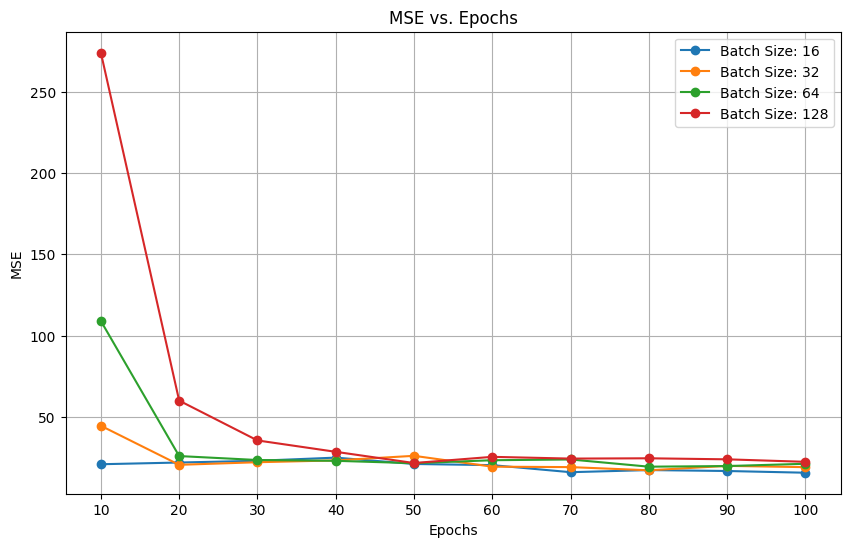

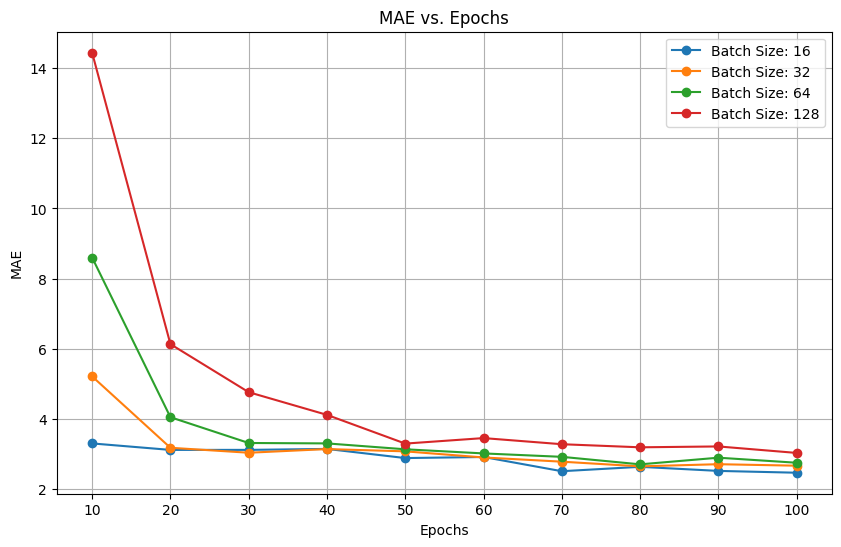

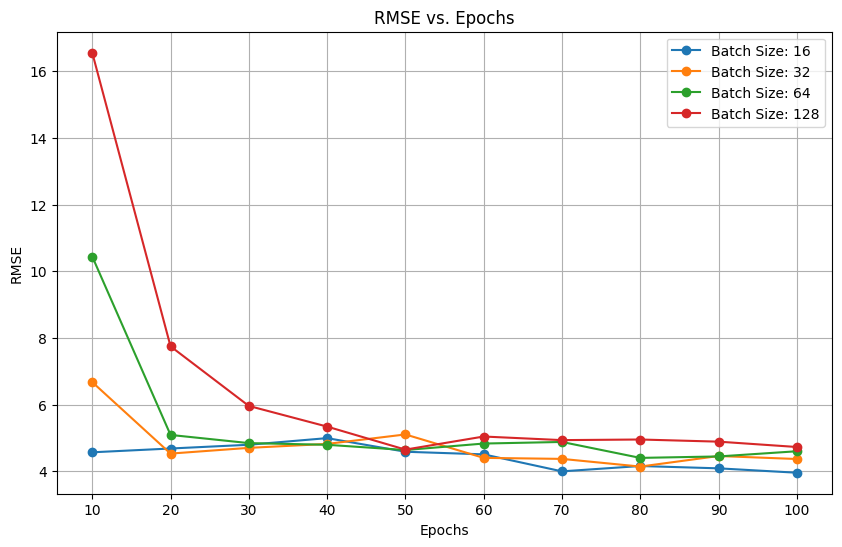

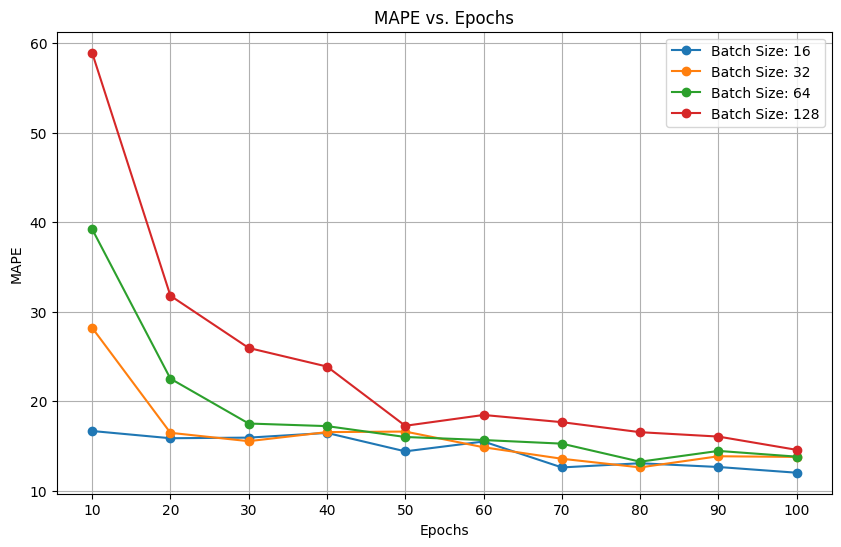

In [56]:
import matplotlib.pyplot as plt
epochs_list = list(range(100, 9, -10))
batch_sizes = [16, 32, 64, 128]

metrics_by_batch_size = {
    batch_size: {
        'mse': [],
        'mae': [],
        'rmse': [],
        'mape': []
    }
    for batch_size in batch_sizes
}

for epochs in epochs_list:
    for batch_size in batch_sizes:
        metrics = results[(epochs, batch_size)]
        for metric_name in ['mse', 'mae', 'rmse', 'mape']:
            metrics_by_batch_size[batch_size][metric_name].append(metrics[metric_name])

metric_names = ['MSE', 'MAE', 'RMSE', 'MAPE']

for metric_name_lower in ['mse', 'mae', 'rmse', 'mape']:
    plt.figure(figsize=(10, 6))
    for batch_size, metrics in metrics_by_batch_size.items():
        plt.plot(epochs_list, metrics[metric_name_lower], marker='o', label=f'Batch Size: {batch_size}')

    plt.title(f'{metric_names[metric_names.index(metric_name_lower.upper())]} vs. Epochs')
    plt.xlabel('Epochs')
    plt.ylabel(metric_names[metric_names.index(metric_name_lower.upper())])
    plt.xticks(epochs_list)
    plt.legend()
    plt.grid(True)
    plt.show()

In [57]:
predictions = model_original.predict(test_data)
predictions[0]
print(f"Actual Price: {test_targets[0]}, Predicted Price: {predictions[0][0]}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Actual Price: 7.2, Predicted Price: 9.28292465209961


In [58]:
#迴歸問題的數值預測分別使用
#MAE、RMSE 與 MAPE 指標。
#分析淺層神經網路及深度神經網路對訓練資料集及測試資料集之預測績效的影響(課程投
'''
1.分析不同的隱藏層數量及節點數量之影響
2.分析隱藏層的激活函數使用 Sigmoid、Softplus 或 ReLU，對訓練資料集及測試資料集之預測績效的影響
3.分析設定不同的 batch size 及 epoch，對訓練模型所需之訓練時間以及模型預測績效之影響

'''

'\n1.分析不同的隱藏層數量及節點數量之影響\n2.分析隱藏層的激活函數使用 Sigmoid、Softplus 或 ReLU，對訓練資料集及測試資料集之預測績效的影響\n3.分析設定不同的 batch size 及 epoch，對訓練模型所需之訓練時間以及模型預測績效之影響\n\n'